# Anderson localization and Krylov Subspace Methods

In this chapter, we are going to explore the phenomenon of Anderson localization in disordered systems in order to see how Krylov subspace methods can aid with studying this phenomenon in the limit of large systems.

Preamble: Run the cells below to import the necessary Python packages

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/williamgilpin/cphy/blob/main/talks/krylov_methods.ipynb)


In [1]:
import numpy as np
from IPython.display import Image, display

import matplotlib.pyplot as plt
%matplotlib inline


# The tight-binding Hamiltonian

In a crystal with weakly overlapping orbitals, electrons hop between neighboring sites with a rate given by the binding strength $J$. Static impurities at each shift the on-site energies ($\epsilon_i$), giving rise to the tight-binding model
$$
    \mathcal{H} = \sum_i \epsilon_i\,|i\rangle\langle i| - J \!\!\sum_{i,j} A_{ij} \big(|i\rangle\langle j|+|j\rangle\langle i|\big),
$$,
where the vector $|i\rangle \in \mathbb{R}^N$ is a unit vector localized on site $i$, describing the case where an electron is exactly localized at $i$. The first summation over all sites $i$ gives the on-site energy of an electron at site $i$, and it corresponds to an identity matrix. The second summation gives the hopping terms between connected sites, where $A_{ij}$ is the adjacency matrix of the lattice (i.e., $A_{ij}=1$ if sites $i$ and $j$ are connected, and $A_{ij}=0$ otherwise). Because we have defined a separate on-site term, $A_{ii} = 0$ by convention.
For the particular case where the sites are arranged in a one-dimensional chain, the adjacency matrix has off-diagonal terms $A_{ij} = \delta_{i,j+1} + \delta_{i,j-1}$, and the Hamiltonian matrix $\mathcal{H}$ is tridiagonal. 

The Hamiltonian therefore has the form of an $N \times N$ matrix, which gives the probability amplitude for an electron to hop from site $j$ to $i$. In the standard version of this model, the on-site energies $\epsilon_i$ are drawn from a uniform distribution $[-W/2,W/2]$, where $W$ is the disorder strength. 

### Implementing the tight-binding Hamiltonian in Python

Below, we implement this case as a Python object. We store the physical parameters as instance attributes assigned when the object is initialized. We define a single method, `energy` that materializes the full Hamiltonian matrix. We add a decorator `@property`, which tells Python to treat the method as an attribute, so that we can call it as `H.energy` instead of `H.energy()`. This is a common Python idiom for attributes that are expensive to compute, but which we want to appear as simple attributes. It represents an example of lazy evaluation, where the value is only computed when it is needed. By default, Python does not cache outputs marked with `@property`, so the matrix will be re-computed each time it is accessed. However, advanced decorators such as `@functools.cached_property` can be used to cache the output after the first computation.


Text(0, 0.5, 'Site Index j')

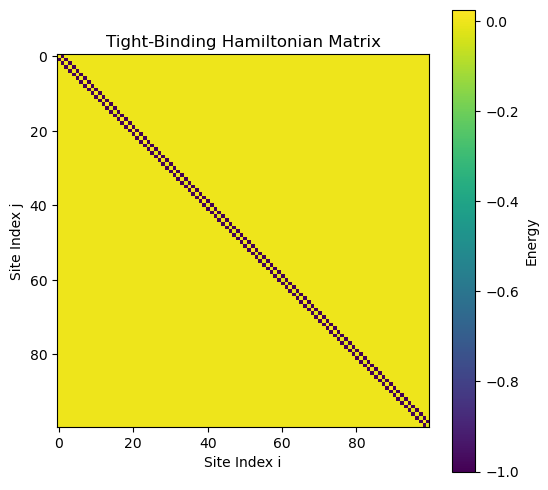

In [9]:
class TightBindingModel:
    def __init__(self, J, w, n, random_state=None):
        self.J = J
        self.w = w
        self.n = n

        self.random_state = random_state
        np.random.seed(self.random_state)

        self.epsilon = np.random.uniform(-self.w / 2, self.w / 2, self.n)

    @property
    def energy(self):
        H = np.zeros((self.n, self.n))

        for i in range(self.n):
            H[i, i] = self.epsilon[i]
            if i < self.n - 1:
                H[i, i + 1] = -self.J
                H[i + 1, i] = -self.J

        return H

tbh = TightBindingModel(J=1, w=0.05, n=100, random_state=0)

plt.figure(figsize=(6, 6))
plt.imshow(tbh.energy, cmap='viridis', interpolation='nearest')
plt.title('Tight-Binding Hamiltonian Matrix')
plt.colorbar(label='Energy')
plt.xlabel('Site Index i')
plt.ylabel('Site Index j')

The spectrum of the matrix $H$ gives the energy levels of the system, and the eigenvectors give the wavefunctions of the electrons associated with that energy level,
$$
    \mathcal{H} |\psi_n\rangle = E_n |\psi_n\rangle.
$$
where $E_n$ is the energy of the $n$th eigenstate, and $|\psi_n\rangle$ is the corresponding eigenvector. The eigenvectors are normalized such that $\langle \psi_n | \psi_n \rangle = 1$. To convert a wavefunction into a probability distribution, we take the square of the coefficients, $P_n(i) = |\langle i | \psi_n \rangle|^2$, which gives the probability of finding an electron in state $n$ at site $i$.


Text(0, 0.5, 'Eigenvalue (Energy)')

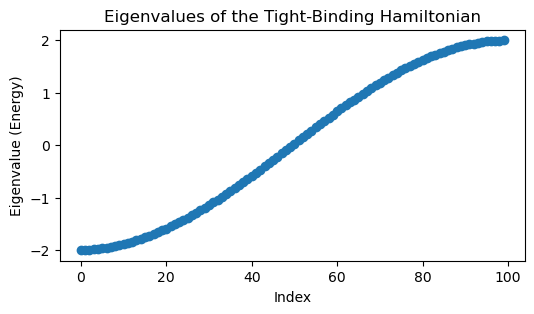

In [10]:
eigvals, eigvecs = np.linalg.eigh(tbh.energy)
plt.figure(figsize=(6, 3))
plt.plot(eigvals, 'o')
plt.title('Eigenvalues of the Tight-Binding Hamiltonian')
plt.xlabel('Index')
plt.ylabel('Eigenvalue (Energy)')

Notice how all of the eigenvalues, and thus energies, are real, as we would expect for a physical system. This is because $H$ is a symmetric matrix, and so real eigenvalues are guaranteed by the spectral theorem.

We are particularly interested in the low-temperature state of this system, which is the eigenvector associated with the lowest eigenvalue of $H$. This eigenvector tells us how an electron would be distributed across the sites in the ground state of the system.

Text(0.5, 0, 'Site Index')

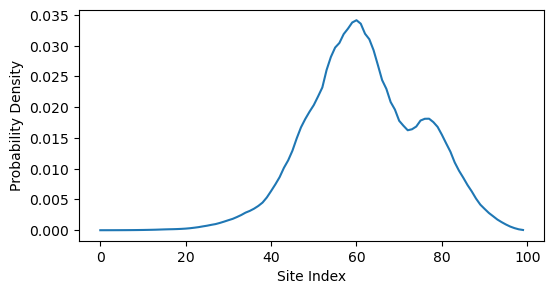

In [11]:
min_index = np.argmin(eigvals)
plt.figure(figsize=(6, 3))
plt.plot(eigvecs[:, min_index] ** 2)
plt.ylabel('Probability Density')
plt.xlabel('Site Index')

What happens if we increase the disorder in the system? 

Text(0.5, 1.0, 'Ground State Probability Density (High Disorder)')

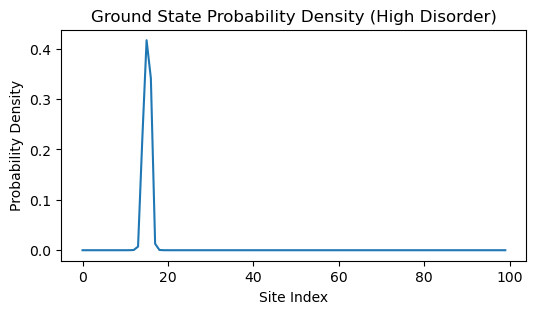

In [13]:
tbh = TightBindingModel(J=1, w=5, n=100, random_state=0)
eigvals, eigvecs = np.linalg.eigh(tbh.energy)
min_index = np.argmin(eigvals)
plt.figure(figsize=(6, 3))
plt.plot(eigvecs[:, min_index] ** 2)
plt.ylabel('Probability Density')
plt.xlabel('Site Index')
plt.title('Ground State Probability Density (High Disorder)')

We can see that, increasing the disorder strength $W$ causes the eigenvector to become more localized around a few sites. This is a hallmark of [**Anderson localization**](https://doi.org/10.1103/PhysRev.109.1492), where disorder in the system causes electrons to become trapped in certain regions rather than being able to move freely throughout the material.

## Anderson localization on complex networks

Let's now try to study Anderson localization in a larger system. Rather than continue the case where the sites are arranged in a 1D chain, let's now consider a system with a more complex topology. We'll start with a 1D chain, but we will introduce random long-range connections between sites by randomly choosing pairs of sites and connecting them with probability $p \ll 1$. This results in a disordered ["small-world" network](https://doi.org/10.1038/30918), which is more representative of real materials where electrons can hop between distant sites due to impurities or defects.

Note that there are now two sources of quenched disorder in our problem: the random on-site energies $\epsilon_i$ and the random long-range connections between sites.

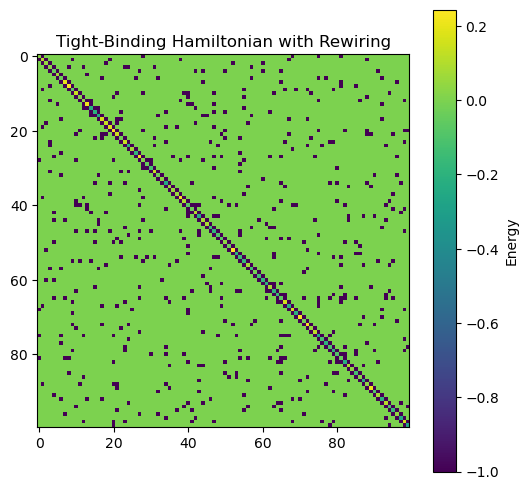

In [15]:
class TightBindingRewiring(TightBindingModel):
    def __init__(self, p, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.p = p

    @property
    def energy(self):
        H = super().energy

        for i in range(self.n):
            for j in range(i + 2, self.n):
                if np.random.rand() < self.p:
                    H[i, j] = -self.J
                    H[j, i] = -self.J

        return H

H = TightBindingRewiring(J=1, w=0.5, n=100, p=0.05, random_state=0)
plt.figure(figsize=(6, 6))
plt.imshow(H.energy, cmap='viridis', interpolation='nearest')
plt.title('Tight-Binding Hamiltonian with Rewiring')
plt.colorbar(label='Energy')


Text(0.5, 0, 'Site Index')

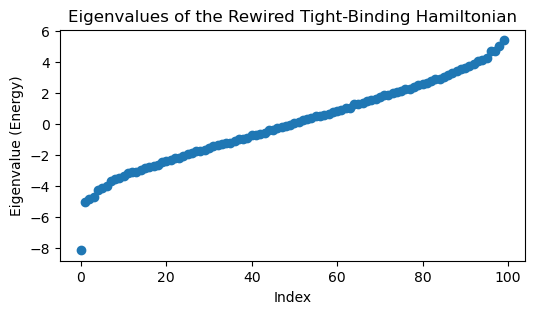

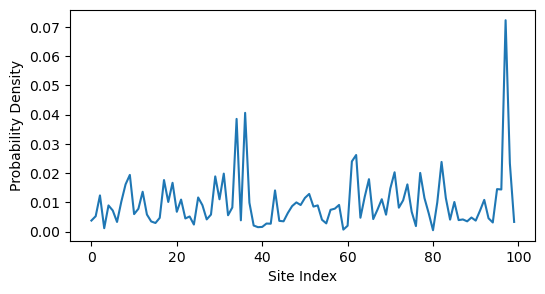

In [16]:
eigvals, eigvecs = np.linalg.eigh(H.energy)
plt.figure(figsize=(6, 3))
plt.plot(eigvals, 'o')
plt.title('Eigenvalues of the Rewired Tight-Binding Hamiltonian')
plt.xlabel('Index')
plt.ylabel('Eigenvalue (Energy)')
min_index = np.argmin(eigvals)
plt.figure(figsize=(6, 3))
plt.plot(eigvecs[:, min_index] ** 2)
plt.ylabel('Probability Density')
plt.xlabel('Site Index')

We can see that random rewiring disrupts the localized state. This is because long-range connections alter the topology of the network; the wavefunction may localize on the graph itself, but the graph is no longer embedded in a simple 1D space. In fact, the localized nodes map onto a community within the network, similar to our previous spectral graph theory example. 

**What happens if we try to scale up our calculation to a much larger system?** Let's try repeating our calculation with $N=10,000$ sites.

In [20]:
H = TightBindingRewiring(J=1, w=0.5, n=10000, p=0.05, random_state=0)
eigvals, eigvecs = np.linalg.eigh(H.energy)

On most hardware, this calculation will not complete in a reasonable amount of time. The problem is that the Hamiltonian matrix $H$ is now $10,000 \times 10,000$. Finding the full eigenvalue spectrum thus requires $O(N^3) = O(10^{12})$ operations, which is infeasible on a standard laptop. However, we suspect that we are wasting a lot of time computing eigenvalues and eigenvectors that we don't care about. Because we are only interested in the lowest energy eigenvalue and its associated eigenvector, rather than the full spectrum.

<br>
<br>
<br>

## Concentration of measure in high dimensions

To understand how we might accelerate our eigenspace calculation, we can gain some intuition from the field of high-dimensional geometry. In high-dimensional spaces, many counterintuitive phenomena arise due to the so-called "concentration of measure" effect. This effect states that in high-dimensional spaces, most of the volume of a shape is concentrated in a thin shell near its surface.

Below, we generate a random Hermitian matrix $A \in \mathbb{R}^{N \times N}$ of increasing size $N$, and we also generate a random vector $\mathbf{b}$. We compute the angle between the vector $\mathbf{b}$ and the vector $A\mathbf{b}$ as the size of the space $N$ increases.


Text(0, 0.5, 'Angle between $b$ and $A @ b$')

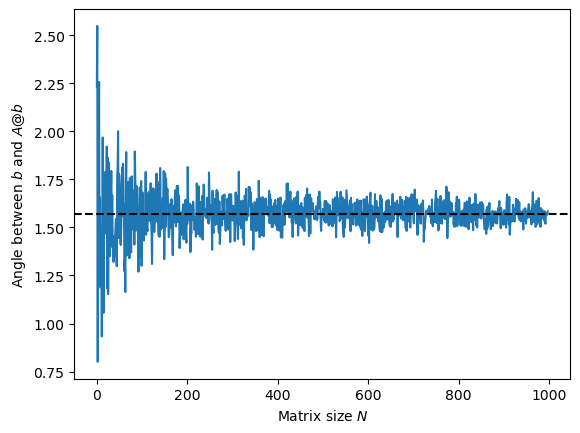

In [5]:
all_angles = list()
for n in range(2, 1000):
    ## Create a random Hermitian matrix
    A = np.random.normal(size=(n, n))
    A = A.T + A 
    b = np.random.normal(size=(n,)) 
    bprime = A @ b
    all_angles.append(
        np.arccos(np.dot(b / np.linalg.norm(b), bprime / np.linalg.norm(bprime)))
    )
plt.plot(all_angles)
plt.axhline(np.pi/2, 0, 1000, color='k', linestyle='--')
plt.xlabel('Matrix size $N$')
plt.ylabel('Angle between $b$ and $A @ b$')


The angle quickly converges to $\pi / 2$, indicating that the vectors $\mathbf{b}$ and $A\mathbf{b}$ are nearly orthogonal in high dimensions. This is a manifestation of the concentration of measure effect, where random vectors in high-dimensional spaces tend to be nearly orthogonal to each other. The fact that $A\mathbf{b}$ is nearly orthogonal to $\mathbf{b}$ suggests that the large matrix rotates the vector $\mathbf{b}$ in a fully random direction.

What does this mean, in practice? If we are given a matrix $A$ and a vector $b$ in high dimensions, then we can find orthogonal basis directions quickly with individual matrix-vector products.

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

# Krylov subspace methods

Many iterative algorithms for numerical linear algebra involve repeatedly multiplying a matrix by a vector in order to build up a solution gradaully. For example, the QR eigenvalue algorithm repeatedly multiplies a matrix by an matrix corresponding to an orthogonal basis set of vectors, while the power method repeatedly multiplies a matrix by a vector. 

Our choice of target vector $\mathbf{b}$ and the matrix operator $A$ jointly define the *Krylov subspace* of the pair

$$
    {\displaystyle {\mathcal {K}}_{r}(A,b)=\operatorname {span} \,\{b,Ab,A^{2}b,\ldots ,A^{r-1}b\}.}
$$

The subspace in question refers to the span of the vectors $\{b, Ab, A^2b, \ldots, A^{r-1}b\}$, which is a subspace of full the column span of $A$. While the full column span is a property of $A$ alone, the specific subspace depends on $\mathbf{b}$. When the number of columns in $A$ is less than the number of rows ($M < N$) the rank $r$ of the Krylov subspace can range from $1$ to $r_{max} \leq \text{rank}(A) + 1$. The $+1$ comes from the special case where $\mathbf{b}$ is not in the column span of $A$. However, when $A$ is a full-rank square matrix, then $r_{max} = N$.

We store the vectors spanning the Krylov subspace in a matrix $Q_r = [q_1, q_2, \ldots, q_r]$, where each $q_i$ is a column vector and $Q_r \in \mathbb{R}^{N \times r}$. Each iteration adds a basis element to this set, and thus increases the number of columns in $Q_r$ by one.

### Properties of the Krylov subspace

There are a few key properties of Krylov subspaces, around which we can build iterative algorithms:

+ **Shifting.** Applying the matrix $A$ to the Krylov subspace $Q_r$ performs a shift on the Krylov subspace: $\displaystyle {\mathcal {K}}_{r}(A,b),A{\mathcal {K}}_{r}(A,b)\subset {\mathcal {K}}_{r+1}(A,b)$.
+ **Rank.** If $r > r_{max}$, then the Krylov subspace is rank-deficient, and so there are linearly dependent vectors in the column span of the subspace matrix $Q_r$.
+ **Span.** If $A$ is a full-rank $N \times N$ matrix, then $Q_{r_\text{max}} = {\mathcal {K}}_{r_{max}}(A,b)$ is also a full-rank $N \times N$ matrix. 

The main reason that we are interested in Krylov subspace methods is because we can perform cheap matrix-vector products ($\mathcal{O}(N^2)$) to extend the space. Often, the matrix $A$ encodes our dataset, simulation, or other fixed set of constraints, and the vector $\mathbf{b}$ encodes our initial guess, prior knowledge, or an error term that we seek to minimize.

Common examples of Krylov subspace methods include the power method and inverse methods for finding the largest and smallest eigenvalues of matrices, and the Lanczos algorithm for finding eigenvalues and eigenvectors of a large sparse matrix, and the GMRES, MINRES, and conjugate gradient method for solving systems of linear equations.

<!-- Suppose a linear equation has a residual vector:
$$
    \mathbf{r} = A \mathbf{x} - \mathbf{b}
$$
For example, if we are performing partial linear regression, then the residual denotes our error terms -->
<!-- 
Different Krylov subspace methods boil down to choosing a vector $\mathbf{x}$, and thus subspace $\mathcal {K}_{j}(A,b)$, for which the residual satisfies certain desiderata:

1. Minimize $|| \mathbf{r} ||$. Iterative least-squares via GMRES, MINRES
2. Minimize $|| {\mathcal{K}_j} \cdot\mathbf{r} ||$ (find orthogonal residual). Conjugate gradient method

where $\mathcal{K}_j$ is shorthand for $\mathcal {K}_{j}(A,b)$. In these iterative algorithms, we seek to minimize the desired cost function at each step $i$, corresponding to a single power iteration of the matrix.  -->



### Testing the properties of Krylov subspaces

In the code below, we explore the structure of Krylov subspaces when $N=100$ and then when $N=1000$. We generate a random symmetric matrix $A$ and a random vector $\mathbf{b}$, and we iteratively build up the Krylov subspace by repeatedly multiplying $A$ by the current basis vector. At each iteration, we measure the condition number of the Krylov subspace matrix $Q_r$ A high condition number indicates that the matrix is close to being rank-deficient, while a low condition number indicates that the matrix is well-conditioned, with full rank and nearly-orthogonal columns.

N = 100 Condition numbers: 1.00, 2.62 ,... 2.53e+18, 3.10e+18
N = 1000 Condition numbers: 1.02, 2.53 ,... 3.90e+19, 1.16e+20


Text(0, 0.5, 'Condition number')

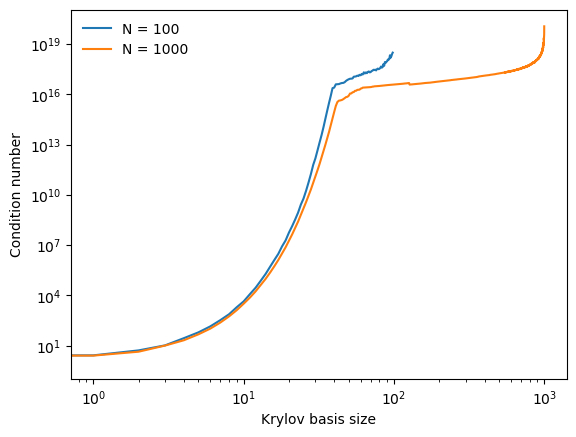

In [80]:

for nval in [100, 1000]:
    # nval = 200

    ## Create a random Hermitian matrix
    np.random.seed(1)
    A = np.random.normal(size=(nval, nval))
    A = A.T + A 

    ## Create a random starting basis vector
    b = np.random.normal(size=(nval,)) 
    b /= np.linalg.norm(b)

    krylov_basis = [b]
    condition_numbers = list()
    for i in range(1, nval):
        
        ## Multiply the last vector in the Krylov basis by A
        krylov_i = A @ krylov_basis[-1]
        krylov_i /= np.linalg.norm(krylov_i)
        krylov_basis.append(krylov_i)

        condition_numbers.append(np.linalg.cond(np.array(krylov_basis)))
    krylov_basis = np.array(krylov_basis)
    condition_numbers = np.array(condition_numbers)
    print(f"N = {nval} Condition numbers: {", ".join(f"{x:.2f}" for x in condition_numbers[:2])} ,... {", ".join(f"{x:.2e}" for x in condition_numbers[-2:])}")
    
    plt.loglog(condition_numbers, label=f"N = {nval}")

plt.legend(frameon=False)
plt.xlabel('Krylov basis size')
plt.ylabel('Condition number')



We can see that the condition number of the higher-dimensional Krylov subspace initially grows more slowly than the lower-dimensional case, though it will eventually surpass it because it can be iterated for a larger number of steps. This slower initial growth is a consequence of the concentration of measure phenomenon, because the early basis vectors are more likely to be orthogonal to each other, and so the condition number is lower.

However, at the end stages of the Krylov iteration, the condition number grows larger for the higher-dimensional case. We know from previous chapters that the condition number of a random $N \times N$ matrix is $O(N)$ due to the birthday paradox. However, we see instead that the condition number is much, much higher. This implies that the Krylov subspace is saturating onto a lower-dimensional subspace than $N$, resulting in vectors that are closer to parallel than would be expected in the case where each vector is sampled entirely randomly. We thus suspect that, in high dimensions, the dynamics of $A \mathbf{x}$ are more constrained than random sampling would imply.

### What does the Krylov subspace look like?

To help understand the shape of the Krylov subspace, we take the elementwise average of the entire Krylov basis set, resulting in a single $N$-dimensional vector. We compare this to the eigenvector associated with the largest eigenvalue of $A$.



Text(0, 0.5, 'Leading eigenvector of A')

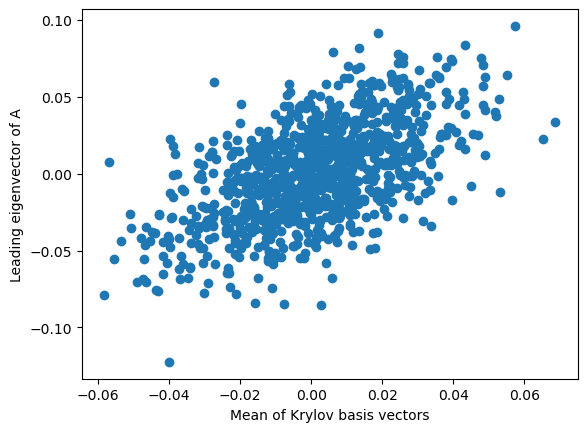

In [91]:
# Find the true eigenvalues and eigenvectors and sort in descending order of eigenvalue magnitude
eigenvalues, eigenvectors = np.linalg.eigh(A)
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Find the average of the Krylov basis vectors
average_krylov_element = np.mean(krylov_basis, axis=0)

plt.plot(average_krylov_element, eigenvectors[:, 0], 'o')
plt.xlabel('Mean of Krylov basis vectors')
plt.ylabel('Leading eigenvector of A')

We can see that the Krylov subspace is concentrated around the largest eigenvector of $A$. This is a consequence of **the power method**, which itself states that linear dynamical systems asymptotically pull points onto a lower-dimensional subspace associated with the largest eigenvalue. But what about the other eigenvectors? We have an $N \times N$ Krylov subspace, as well as a set of $N$ eigenvectors of $A$. How do these two sets of vectors relate to each other?

To test this relationship, we compute the dot product between each eigenvector and each Krylov basis vector, resulting in an $N \times N$ matrix of dot products. Since both bases consist of normalized unit vectors, we can interpret the dot products as cosines of angles between the vectors, or, equivalently, the Pearson correlation between each element of the Krylov subspace and each true eigenvector.

In [93]:
# Find the inner product of the ith Krylov basis vector with the jth eigenvector
inner_product = krylov_basis @ eigenvectors

Text(0, 0.5, 'Inner product with true eigenvector (normalized)')

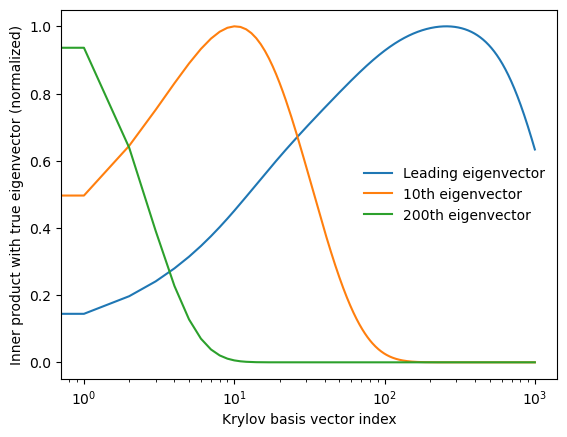

In [117]:
plt.semilogx(np.abs(inner_product)[:, 0] / np.max(np.abs(inner_product)[:, 0]), label='Leading eigenvector')
plt.semilogx(np.abs(inner_product)[:, 10] / np.max(np.abs(inner_product)[:, 10]), label='10th eigenvector')
plt.semilogx(np.abs(inner_product)[:, 200] / np.max(np.abs(inner_product)[:, 200]), label='200th eigenvector')
plt.legend(frameon=False)
plt.xlabel('Krylov basis vector index')
plt.ylabel('Inner product with true eigenvector (normalized)')

We can see that each true eigenvector is associated with a different timescale in the Krylov iteration. Less important eigenvectors associated with smaller eigenvalues only correlate with the Krylov basis vector early on, but the most important eigenvectors associated with the largest eigenvalues correlate with later Krylov basis vectors. The Krylov basis therefore gradually squeezes directions out of the system, resulting in a low-dimensional subspace associated with the largest eigenvalues of $A$.

<br>
<br>
<br>
<br>
<br>

## Arnoldi iteration as a Krylov method

Arnoldi iteration is an eigenvalue and eigenvector algorithm that uses the Krylov subspace to iteratively construct an orthogonal basis for a matrix $A$. It is similar to the QR eigenvalue algorithm, but it allows us to stop after the first $m \ll n$ terms of the factorization of the full matrix $A \in \mathbb{R}^{N \times N}$. As a result, while $QR$ factorization is $O(N^3)$ and returns the full set of eigenvalues and eigenvectors, Arnoldi iteration is $O(m N^2)$ and returns only $m$ eigenvalues and eigenvectors

<!-- $$
\begin{align}
A
\left[ \begin{array}{cccc}
\mathbf{q}_1 & \mathbf{q}_2 & \cdots & \mathbf{q}_m
\end{array} \right] &=
\left[ \begin{array}{cccc}
\mathbf{q}_1 & \mathbf{q}_2 & \cdots & \mathbf{q}_{m+1}
\end{array} \right]
\left[ \begin{array}{cccc}
h_{1,1} & h_{1,2} & \cdots & h_{1,m} \\
h_{2,1} & h_{2,2} & \cdots & h_{2,m} \\
0 & h_{3,2} & \cdots & h_{3,m} \\
\vdots & \vdots & \ddots & \vdots \\
0 & 0 & \cdots & h_{m+1,m}
\end{array} \right] 
\end{align}
$$ -->

### The Arnoldi algorithm

1. Choose a random starting vector $\mathbf{q}_1$ of length $N$ and normalize it to have unit length
2. For $k = 1, 2, \ldots, m$:
    1. Find the next candidate Krylov subspace element by computing $v_m = A q_m$.
    2. For $j = 1, 2, \ldots, k$:
        1. Compute the projection of each prior subspace vector onto the new element $h_{jk} = \langle q_j, v_k \rangle$
        2. Perform a single Gram-Schmidt update $v_k = v_k - h_{j,k} q_j$
    3. Compute the normalization constant $h_{k+1,k} = || v_k ||$
    4. Compute the final new basis element $q_{k+1} = v_k / h_{k+1,k}$
3. Return $Q_m \in \mathbb{R}^{N \times m}$ and $\tilde{H}_m$


### Ordering the Arnoldi algorithm

As we saw previously for Gram-Schmidt, this approach does not necessarily give us the eigenvectors in order of decreasing eigenvalue and thus relevance to our problem. To fix this, we can manipulate the starting direction of the iteration by exploiting some properties of high-dimensional vector spaces. The first will be to use a *warm start*. Rather than picking a randomly-oriented starting vector $\mathbf{q}_1$, we will instead pick a starting vector aligned with the average bearing direction of the column space.

We then immediately construct an order $k$ Krylov subspace, starting from this vector. We know that dynamical systems tend to concentrate around the leading eigenvector, and so we orthogonalize with Gram-Schmidt in the *reverse* order of the original iteration, so that the first eigenvector (the one around which we orthogonalize first) is the one associated with the largest eigenvalue. This is a simple modification to the Arnoldi algorithm, but it results in a much more useful ordering of the eigenvectors.



(np.float64(-0.018953520699790626),
 np.float64(-0.017780021102231286),
 np.float64(0.01778003795677678),
 np.float64(0.01895350553644324))

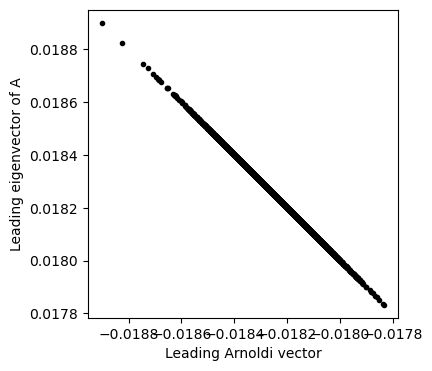

In [ ]:
class Arnoldi:
    def __init__(self, random_state=None, store_history=False):
        self.random_state = random_state
        np.random.seed(self.random_state)
        self.store_history = store_history
        if self.store_history:
            self.history = list()

    def solve(self, A, k):
        n = A.shape[0]

        ## Warm start using the column average
        q = np.mean(A, axis=0)
        q /= np.linalg.norm(q)

        ## Iterate to build the Krylov subspace
        self.krylov_basis = [q]
        for i in range(1, k):
            vi = A @ self.krylov_basis[-1].copy()
            self.krylov_basis.append(vi / np.linalg.norm(vi))

        ## Reverse the order of vectors, under the assumption that the last vector
        ## has the most weight in the leading eigenvector
        self.krylov_basis = self.krylov_basis[::-1]

        ## Now run Gram-Schmidt orthogonalization
        for i in range(1, k):
            vi = self.krylov_basis[i].copy()

            hi = np.array(self.krylov_basis)[:i] @ vi # Project onto the existing basis
            vi -= hi @ np.array(self.krylov_basis)[:i] # Gram-Schmidt orthogonalization
            qi = vi / np.linalg.norm(vi)
            self.krylov_basis[i] = qi

            nrm = np.linalg.norm(vi)
            self.krylov_basis[i] = vi / nrm

            if self.store_history:
                self.history.append(np.array(self.krylov_basis[:i+1]))

        return np.array(self.krylov_basis).T

## Make a random Hermitian matrix and regression target
np.random.seed(0)
a_big = np.random.random((3000, 3000))
a_big = a_big.T + a_big

## Find only the first 5 Arnoldi vectors
arnoldi_vectors = Arnoldi(random_state=0).solve(a_big, 5)

## Get numpy eigenvalues and eigenvectors and sort in descending order of eigenvalue magnitude
eigenvalues, eigenvectors = np.linalg.eigh(a_big)
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

## Compare numpy eigenvectors to Arnoldi vectors
plt.figure(figsize=(4, 4))
plt.plot(arnoldi_vectors[:, 0], eigenvectors[:, 0], '.k')
plt.xlabel('Leading Arnoldi vector')
plt.ylabel('Leading eigenvector of A')
plt.axis('equal')

## What is going on here?

The full QR factorization of a matrix $A$ can be written the form $A= Q H Q^{-1}$, where $Q, H \in \mathbb{R}^{N \times N}$. $Q$ is an orthogonal matrix, and so the case of full factorization corresponds to rotating the matrix $A$ into a basis where the eigenvectors are the columns. As in QR factorization, the matrix $H$ is upper triangular, and it is known as the Hessenberg matrix.

If we only want to compute the first $m$ eigenvalues of a matrix, then we we seek a low-rank approximation of $Q$. The partial basis $Q_m \in \mathbb{R}^{N \times M}$, $M \leq N$ has the property
$$
    Q_{m + 1}^{-1} A Q_m =  \tilde{H}_m
$$
where $\tilde{H}_m \in \mathbb{R}^{(M+1) \times M}$ is the first $m$ and $m+1$ elements of the full Hessenberg matrix $H$. Our output is the reduced matrix $Q_m$. Each iteration finds a new basis vector for the corresponding rank-$k$ Krylov subspace. After stopping at our $m$ of interest, we can find the reduced Hessenberg matrix $H_m = Q_m^* A Q_m$, where $H_m \in \mathbb{R}^{M \times M}$.

<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>

## Finding subleading eigenvalues with the deflation method

The approach above works for our purposes because we are only interested in the leading eigenvector of the system. The subleading directions will be returned in an arbitrary order. We can extend this approach to a full reordering of the eigenvectors by applying the same logic again. After finding the leading eigenvector, we can project it out of the matrix $A$ using a rank-1 update, and then repeat the Arnoldi iteration on the modified matrix. This will return the second eigenvector, which we can again project out of the matrix, and so on. This approach is called the *deflation method*, and it is a common technique for finding multiple eigenvalues and eigenvectors of a matrix.

The key step that makes deflation work is that we can remove a subspace from the row and column space of a matrix. If we want to remove the leading eigenvector $\mathbf{v}_1$ associated with eigenvalue $\lambda_1$, we perform the rank-1 update,
$$
    A' = A - \lambda_1 \mathbf{v}_1 \mathbf{v}_1^T,
$$
This step removes the first-order approximation of the matrix $A$ via the singular value decomposition of $A$. The new matrix $A'$ has the same eigenvectors as $A$, but the leading eigenvector of $A'$ is now the second eigenvector of $A$. We can thus repeat the Arnoldi iteration on $A'$ to find the second eigenvector, and so on. In order to deflate out multiple subspaces at once, we can once again invoke notation from the singular value decomposition. If we have already found $m$ eigenvectors, we can store them in a matrix $V_m = [\mathbf{v}_1, \mathbf{v}_2, \ldots, \mathbf{v}_m]$, and their associated eigenvalues in a diagonal matrix $\Lambda_m = \text{diag}(\lambda_1, \lambda_2, \ldots, \lambda_m)$. We can then perform the rank-$m$ update,
$$
    A' = A - V_m \Lambda_m V_m^T,
$$
to remove the subspace spanned by the first $m$ eigenvectors. 

### The Rayleigh quotient

We cannot perform deflation with an estimate of the previous $m$ eigenvalues in descending order. It turns out that, after finding an eigenvector $\mathbf{v}_i$, we can estimate the associated eigenvalue $\lambda_i$ using the Rayleigh quotient,
$$
    \lambda_i = \frac{\mathbf{v}_i^T A \mathbf{v}_i}{\mathbf{v}_i^T \mathbf{v}_i}
$$
where the denominator is simply a normalization constant that we can safely ignore if $\mathbf{v}_i$ is already unit vector.


### Implementing the deflated power method

We know that the power method causes a random vector to converge to the leading eigenvector of a matrix $A$. We will implement this procedure as a private method in our `DeflatedPowerMethod` class, because we will need to use it first on the original matrix $A$, and then on the deflated matrix $A'$, and so on. Our implementation will start by finding the leading direction via power iteration, then find the associated eigenvalue via the Rayleigh quotient, and then deflate the matrix and repeat the process.



(np.float64(0.03003694728064225),
 np.float64(0.03300286284201122),
 np.float64(0.030036947280642243),
 np.float64(0.033002862842011225))

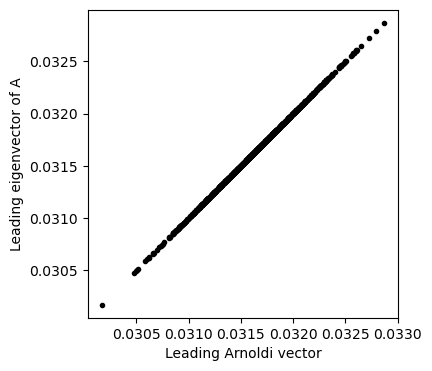

In [261]:
class DeflatedPowerMethod:
    def __init__(self, random_state=None, store_history=False, max_iter=100):
        self.random_state = random_state
        np.random.seed(self.random_state)
        self.store_history = store_history
        self.max_iter = max_iter
        if self.store_history:
            self.history = list()

    def _power_method(self, A, q=None):
        """Given a a matrix A and an optional starting vector q,
        use the power method to find the leading eigenvector of A.
        """
        n = A.shape[0]

        ## If a warm start is not provided, pick a random direction
        if q is None:
            q = np.random.normal(size=(n,))
            q /= np.linalg.norm(q)

        for _ in range(self.max_iter):
            q = A @ q
            q /= np.linalg.norm(q)

        return q

    def solve(self, A, k):
        """Find the first k eigenvectors of A using the deflated power method.
        """

        # Warm start for first eigenvector using the columnwise average
        q = np.mean(A, axis=0)
        q /= np.linalg.norm(q)

        # Power iteration converges to the leading eigenvector
        q = self._power_method(A, q)
        
        self.krylov_basis = [q]
        self.krylov_eigenvalues = [q.T @ A @ q]

        for r in range(1, k):
            
            V = np.array(self.krylov_basis[:r]).T          # (n, r)
            lam = np.array(self.krylov_eigenvalues[:r])           # (r,)
            A_deflated = A - V @ np.diag(lam) @ V.T               # (n, n)

            q = self._power_method(A_deflated)

            self.krylov_basis.append(q)
            self.krylov_eigenvalues.append(q.T @ A @ q)

        return np.array(self.krylov_basis[:k]).T
            


## Make a random Hermitian matrix and regression target
np.random.seed(0)
a_big = np.random.random((1000, 1000))
a_big = a_big.T + a_big

## Find only the first 5 Arnoldi vectors
arnoldi_vectors = DeflatedPowerMethod(random_state=0).solve(a_big, 10)

## Get numpy eigenvalues and eigenvectors and sort in descending order of eigenvalue magnitude
eigenvalues, eigenvectors = np.linalg.eigh(a_big)
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

## Compare numpy eigenvectors to Arnoldi vectors
plt.figure(figsize=(4, 4))
plt.plot(arnoldi_vectors[:, 0], eigenvectors[:, 0], '.k')
plt.xlabel('Leading Arnoldi vector')
plt.ylabel('Leading eigenvector of A')
plt.axis('equal')

Text(0, 0.5, 'Subeading eigenvector of A')

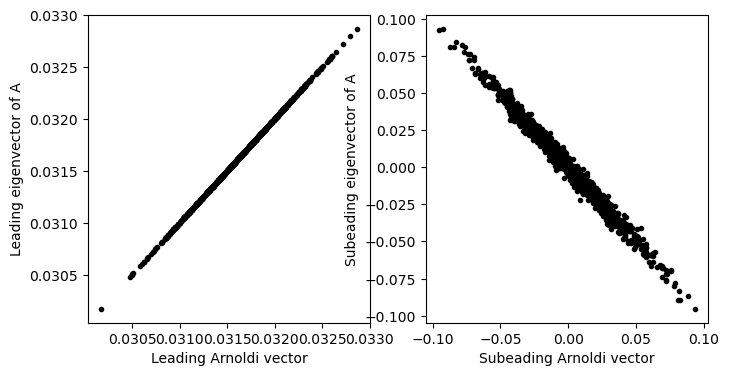

In [265]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(arnoldi_vectors[:, 0], eigenvectors[:, 0], '.k')
plt.xlabel('Leading Arnoldi vector')
plt.ylabel('Leading eigenvector of A')

plt.subplot(1, 2, 2)
plt.plot(arnoldi_vectors[:, 1], eigenvectors[:, 1], '.k')
plt.xlabel('Subeading Arnoldi vector')
plt.ylabel('Subeading eigenvector of A')
# plt.axis('equal')

### How does localization vary with system size?

Now that we have a faster method for computing spectra, we can return to our original problem of computing Anderson localization on a disordered network.

Text(0.5, 0, 'Site Index')

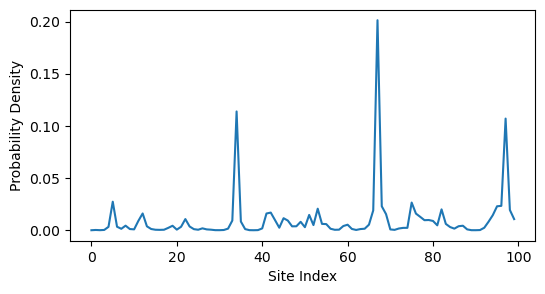

In [185]:
H = TightBindingRewiring(J=1, w=3, n=100, p=0.01, random_state=0)
arnoldi_vectors = Arnoldi(random_state=0, store_history=True).solve(H.energy, 50)
plt.figure(figsize=(6, 3))
plt.plot(arnoldi_vectors[:, 0] ** 2)
plt.ylabel('Probability Density')
plt.xlabel('Site Index')

Text(0.5, 0, 'Site Index')

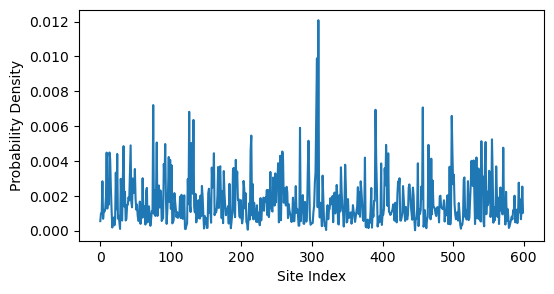

In [187]:
H = TightBindingRewiring(J=1, w=3, n=600, p=0.01, random_state=0)
arnoldi_vectors = Arnoldi(random_state=0, store_history=True).solve(H.energy, 50)
plt.figure(figsize=(6, 3))
plt.plot(arnoldi_vectors[:, 0] ** 2)
plt.ylabel('Probability Density')
plt.xlabel('Site Index')

It looks like the eigenvector becomes more delocalized as $N$ increases. However, it could just appear this way because we are zooming out over more sites. To test this, we can compute the inverse participation ratio (IPR) of the eigenvector, which is a measure of localization that is independent of system size.
The IPR is defined as
$$
    \text{IPR} = \frac{\sum_i |\psi_i|^4}{\left(\sum_i |\psi_i|^2\right)^2}
$$

When this value is close to $1$, the eigenvector is localized on a single site, while when it is close to $1/N$, the eigenvector is delocalized across all $N$ sites. We can repeat our calculation for different system sizes $N$ and plot the IPR as a function of $N$.

Text(0, 0.5, 'Ground State IPR')

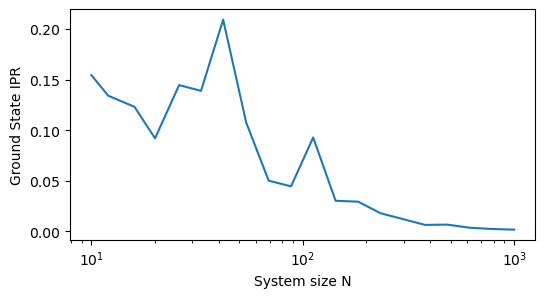

In [190]:
from numpy import astype


def inverse_participation_ratio(psi):
    return np.sum(psi**4) / (np.sum(psi**2)**2)

## Logarithmically spaced sizes from 10^1 to 10^3
nvals = np.logspace(1, 3, 20).astype(int)
all_iprs = list()
for nval in nvals:
    H = TightBindingRewiring(J=1, w=0.6, n=nval, p=0.005, random_state=0)
    eigvals, eigvecs = np.linalg.eigh(H.energy)
    min_index = np.argmin(eigvals)
    psi = eigvecs[:, min_index]
    inverse_participation_ratio(psi)
    all_iprs.append(inverse_participation_ratio(psi))

plt.figure(figsize=(6, 3))
plt.semilogx(nvals, all_iprs)
plt.xlabel('System size N')
plt.ylabel('Ground State IPR')

This calculation confirms our intuition, that the system becomes more delocalized as the number of sites increaes. This is a common phenomenon in condensed matter physics, where larger systems tend to have more delocalized states due to the increased relative influence of long-range connections and disorder.
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
<br>
